In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pymc3 as pm
import missingno as msno
import patsy

from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

%load_ext autoreload
%autoreload 2
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

Can not use cuDNN on context None: cannot compile with cuDNN. We got this error:
b'/tmp/try_flags_y_8np9uk.c:4:19: fatal error: cudnn.h: No such file or directory\ncompilation terminated.\n'
Mapped name None to device cuda: GeForce GTX 1080 (0000:01:00.0)


# Problem Introduction

In [20]:
def load_data(filename):
    df = pd.read_csv(filename)
    df.dropna(inplace=True)
    df['NSP'] = df['NSP'].apply(lambda x: str(x))
    return df



train = load_data('Insight_Train_DC.csv')
test = load_data('Insight_Test_DC.csv')

total = train.append(test).reset_index(drop=True)

In [15]:
test.groupby('NSP').count()

,LB,AC,FM,UC,DL,DS,DP,ASTV,MSTV,ALTV,...,Width,Min,Max,Nmax,Nzeros,Mode,Mean,Median,Variance,Tendency
NSP,,,,,,,,,,,,,,,,,,,,,
1,247,247,247,247,247,247,247,247,247,247,...,247,247,247,247,247,247,247,247,247,247
2,141,141,141,141,141,141,141,141,141,141,...,141,141,141,141,141,141,141,141,141,141
3,39,39,39,39,39,39,39,39,39,39,...,39,39,39,39,39,39,39,39,39,39


Assign weighting to each sample based on class.

In [7]:
train['NSP']

0       1.0
1       1.0
2       1.0
3       1.0
4       1.0
5       1.0
6       1.0
7       2.0
8       2.0
9       2.0
10      2.0
11      2.0
12      2.0
13      1.0
14      1.0
15      2.0
16      2.0
17      2.0
18      2.0
19      2.0
20      2.0
21      1.0
22      1.0
23      1.0
24      1.0
25      1.0
26      1.0
27      1.0
28      1.0
29      1.0
       ... 
1669    1.0
1670    1.0
1671    1.0
1672    1.0
1673    1.0
1674    1.0
1675    1.0
1676    1.0
1677    1.0
1678    1.0
1679    1.0
1680    1.0
1681    1.0
1682    1.0
1683    1.0
1684    1.0
1685    1.0
1686    1.0
1687    1.0
1688    1.0
1689    1.0
1690    1.0
1691    1.0
1692    1.0
1693    1.0
1694    2.0
1695    2.0
1696    2.0
1697    2.0
1698    1.0
Name: NSP, dtype: object

In [21]:
weight_scores = (1 / total.groupby('NSP').count()['LB'].values) / sum(1 / total.groupby('NSP').count()['LB'].values)
weights = []
for i in train['NSP'].values:
    weights.append(weight_scores[int(float(i)) - 1])

In [9]:
test.groupby('NSP').count()

,LB,AC,FM,UC,DL,DS,DP,ASTV,MSTV,ALTV,...,Width,Min,Max,Nmax,Nzeros,Mode,Mean,Median,Variance,Tendency
NSP,,,,,,,,,,,,,,,,,,,,,
1,247,247,247,247,247,247,247,247,247,247,...,247,247,247,247,247,247,247,247,247,247
2,141,141,141,141,141,141,141,141,141,141,...,141,141,141,141,141,141,141,141,141,141
3,39,39,39,39,39,39,39,39,39,39,...,39,39,39,39,39,39,39,39,39,39


In [10]:
xcols = [c for c in train.columns if c != 'NSP']
ycols = ['NSP']

x_train = train[xcols]
y_train = train[ycols]

y_train = patsy.dmatrix('NSP', y_train)
y_train = pd.DataFrame(y_train)
y_train

x_test = test[xcols]
y_test = test[ycols]

y_test = patsy.dmatrix('NSP', y_test)
y_test = pd.DataFrame(y_test)
y_test

,0,1,2
0,1.0,1.0,0.0
1,1.0,0.0,0.0
2,1.0,0.0,0.0
3,1.0,0.0,0.0
4,1.0,0.0,0.0
5,1.0,0.0,1.0
6,1.0,0.0,1.0
7,1.0,0.0,1.0
8,1.0,0.0,1.0
9,1.0,0.0,1.0


In [22]:
from sklearn.model_selection import (ShuffleSplit, 
                                     cross_val_score, 
                                     train_test_split)
from sklearn.ensemble import ExtraTreesClassifier, BaggingClassifier
from xgboost import XGBClassifier
rfr = RandomForestClassifier(n_estimators=300, criterion='gini')
rfr.fit(x_train, y_train)

cv = ShuffleSplit(n_splits=5, test_size=0.3)
cross_val_score(rfr, x_train, y_train, cv=cv)


array([ 0.94117647,  0.94313725,  0.93921569,  0.95098039,  0.96078431])

In [23]:
rfr.score(x_test, y_test)

0.82201405152224827

In [14]:
def ecdf(data):
    x, y = np.sort(data), np.arange(1, len(data)+1) / len(data)
    return x, y

In [7]:
df.columns

Index(['LB', 'AC', 'FM', 'UC', 'DL', 'DS', 'DP', 'ASTV', 'MSTV', 'ALTV',
       'MLTV', 'Width', 'Min', 'Max', 'Nmax', 'Nzeros', 'Mode', 'Mean',
       'Median', 'Variance', 'Tendency', 'NSP'],
      dtype='object')

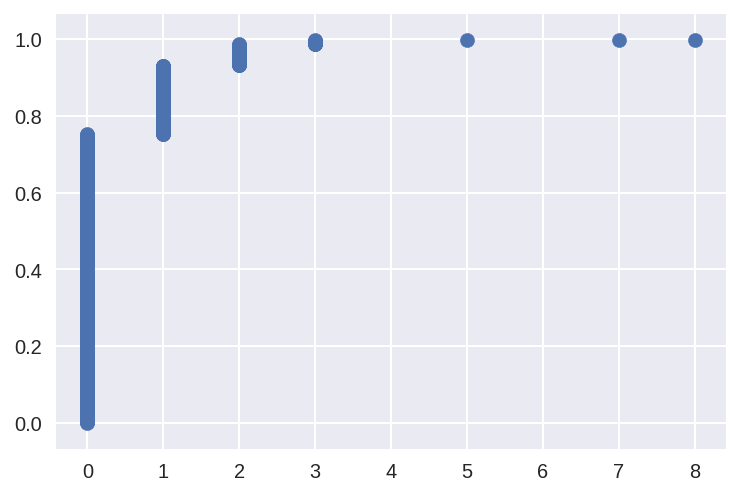

In [30]:
plt.scatter(*ecdf(df['Nzeros']))